# Homework 3: Augmented Reality with Planar Homographies

#### **For each question please refer to the handout for more details.**

Programming questions begin at **Q2**. **Remember to run all cells** and save the notebook to your local machine as a pdf for gradescope submission.

# Collaborators
**List your collaborators for all questions here**:


---

# Q1 Preliminaries

## Q1.1 The Direct Linear Transform


### Q1.1.1 (3 points)

How many degrees of freedom does **h** have?

---

THe degree of freedom of H is n-1. And Matrix H is 3x3 so it has 9 parameters. Therefore, the number of df is 9-1 = 8.

---

### Q1.1.2 (2 points)

How many point pairs are required to solve **h**?

---

Each corresponding point pair
(
𝑥
𝑖
2
,
𝑥
𝑖
1
)
(x
i
2
​
 ,x
i
1
​
 ) provides 2 linear constraints on the 8 unknowns. So we need to solve  (8 unkowns/ 2 constraints per points) = 4 point pairs is the minimum needed to solve.

---

### Q1.1.3 (5 points)

Derive $\textbf{A}_i$

---
A_i
\=\
\begin{pmatrix}
x_i^2 & y_i^2 & 1 & 0 & 0 & 0 & -x_i^1 x_i^2 & -x_i^1 y_i^2 & -x_i^1 \\[6pt]
0 & 0 & 0 & x_i^2 & y_i^2 & 1 & -y_i^1 x_i^2 & -y_i^1 y_i^2 & -y_i^1
\end{pmatrix}

---

### Q1.1.4 (5 points)

What will be the trivial solution for **h**? Is the matrix **A** full rank? Why/Why not? What impact will it have on the singular values (i.e. eigenvalues of $\textbf{A}^T\textbf{A}$)?

---

The trivial soultion is h = 0. Thus, we seek a non-trial $h \neq 0$  that lies in the null space of $A$. The maximum rank A can have is min(2N, 9). For a valid homography solution, we expect the rank of 𝐴 to be 8, not 9. As a result, A is not a full rank ($\neq 9$). Because A has rank 8 (assuming enough point pairs and no degeneracies), there will be exactly one singular value that is zero.

---

## Q1.2 Homography Theory Questions

### Q1.2.1 (5 points)

Prove that there exists a homography **H** that satisfies $\textbf{x}_1 ≡ \textbf{Hx}_2$, given two cameras separated by a pure rotation.

---

We have $x_1 = K_1[I \ 0]X = K_1 X$ and $x_2 = K_2[R \ 0]X = K_2 X$. Since there is no translation, the only difference between the two views is the rotation R. Notice that $x₂= K_2 R X$, so we can solve for X as $X ∝ R^{-1} K_2^{-1} x_2$. Because R is a rotation matrix, its inverse is its transpose,  Now substitute this expression for X back into the equation for $x_1$, x₁ ∝ K₁ X ∝ K₁ (Rᵀ K₂⁻¹ x₂). Thus, $x₁ ≡ H x₂$

---

### Q1.2.2 (5 points):

Show that $\textbf{H}^2$ is the homography corresponding to a rotation of 2$\theta$.

---

The homography be defined as $H=KRK^{−1}$, where R is a rotation by θ. Then, $H^2 = (KRK^{-1})(KRK^{-1}) = KR^2K^{-1}$, Since $R^2$ represents a rotation by 2θ, $H^2$ is the homography corresponding to a rotation of 2θ.

---

# Initialization

Run the following code to import the modules you'll need.

In [ ]:
import os
import numpy as np
import cv2
import skimage.color
import pickle
from matplotlib import pyplot as plt
import scipy
from skimage.util import montage
import time

PATCHWIDTH = 9

def read_pickle(path):
    with open(path, "rb") as f:
        return pickle.load(f)

def write_pickle(path, data):
    with open(path, "wb") as f:
        pickle.dump(data, f)

def briefMatch(desc1,desc2,ratio):

    matches = skimage.feature.match_descriptors(desc1,desc2,
                                                'hamming',
                                                cross_check=True,
                                                max_ratio=ratio)
    return matches

def plotMatches(img1,img2,matches,locs1,locs2):

    fig, ax = plt.subplots(nrows=1, ncols=1)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    plt.axis('off')
    skimage.feature.plot_matched_features(img1,img2,
    keypoints0=locs1,keypoints1=locs2,
    matches=matches,ax=ax,
    matches_color='r',only_matches=True)
    plt.show()
    return

def makeTestPattern(patchWidth, nbits):

    np.random.seed(0)
    compareX = patchWidth*patchWidth * np.random.random((nbits,1))
    compareX = np.floor(compareX).astype(int)
    np.random.seed(1)
    compareY = patchWidth*patchWidth * np.random.random((nbits,1))
    compareY = np.floor(compareY).astype(int)

    return (compareX, compareY)

def computePixel(img, idx1, idx2, width, center):

    halfWidth = width // 2
    col1 = idx1 % width - halfWidth
    row1 = idx1 // width - halfWidth
    col2 = idx2 % width - halfWidth
    row2 = idx2 // width - halfWidth
    return 1 if img[int(center[0]+row1)][int(center[1]+col1)] < img[int(center[0]+row2)][int(center[1]+col2)] else 0

def computeBrief(img, locs):

    patchWidth = 9
    nbits = 256
    compareX, compareY = makeTestPattern(patchWidth,nbits)
    m, n = img.shape

    halfWidth = patchWidth//2

    locs = np.array(list(filter(lambda x: halfWidth <= x[0] < m-halfWidth and halfWidth <= x[1] < n-halfWidth, locs)))
    desc = np.array([list(map(lambda x: computePixel(img, x[0], x[1], patchWidth, c), zip(compareX, compareY))) for c in locs])

    return desc, locs

def corner_detection(img, sigma):

    # fast method
    result_img = skimage.feature.corner_fast(img, n=PATCHWIDTH, threshold=sigma)
    locs = skimage.feature.corner_peaks(result_img, min_distance=1)
    return locs

def loadVid(path):

    # Create a VideoCapture object and read from input file
    # If the input is the camera, pass 0 instead of the video file name

    cap = cv2.VideoCapture(path)

    # get fps, width, and height
    fps = cap.get(cv2.CAP_PROP_FPS)
    width  = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
    height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)

    # Append frames to list
    frames = []

    # Check if camera opened successfully
    if cap.isOpened()== False:
        print("Error opening video stream or file")

    # Read until video is completed
    while(cap.isOpened()):

        # Capture frame-by-frame
        ret, frame = cap.read()

        if ret:
            #Store the resulting frame
            frames.append(frame)
        else:
            break

    # When everything done, release the video capture object
    cap.release()
    frames = np.stack(frames)

    return frames, fps, width, height

# Download data

Download the required data and setup the results directory. If running on colab, DATA_PARENT_DIR must be <br> DATA_PARENT_DIR = '/content/' <br> <br> Otherwise, use the local directory of your choosing. Data will be downloaded to DATA_PARENT_DIR/hw3_data and a subdirectory DATA_PARENT_DIR/results will be created.

In [ ]:
# Only change this if you are running locally
# Default on colab: DATA_PARENT_DIR = '/content/'

# Data will be downloaded to DATA_PARENT_DIR/hw3_data
# A subdirectory DATA_PARENT_DIR/results will be created

DATA_PARENT_DIR = '/content/'

if not os.path.exists(DATA_PARENT_DIR):
  raise RuntimeError('DATA_PARENT_DIR does not exist: ', DATA_PARENT_DIR)

RES_DIR = os.path.join(DATA_PARENT_DIR, 'results')
if not os.path.exists(RES_DIR):
  os.mkdir(RES_DIR)
  print('made directory: ', RES_DIR)


#paths different files are saved to
# OPTIONAL:
# feel free to change if funning locally
ROT_MATCHES_PATH = os.path.join(RES_DIR, 'brief_rot_test.pkl')
ROT_INV_MATCHES_PATH = os.path.join(RES_DIR, 'ec_brief_rot_inv_test.pkl')
AR_VID_FRAMES_PATH = os.path.join(RES_DIR, 'q_3_1_frames.npy')
AR_VID_FRAMES_EC_PATH = os.path.join(RES_DIR, 'q_3_2_frames.npy')

HW3_SUBDIR = 'hw3_data'
DATA_DIR = os.path.join(DATA_PARENT_DIR, HW3_SUBDIR)
ZIP_PATH = DATA_DIR + '.zip'
if not os.path.exists(DATA_DIR):
  !wget 'https://www.andrew.cmu.edu/user/hfreeman/data/16720_spring/hw3_data.zip' -O $ZIP_PATH
  !unzip -qq $ZIP_PATH -d $DATA_PARENT_DIR

made directory:  /content/results
--2025-02-25 14:30:12--  https://www.andrew.cmu.edu/user/hfreeman/data/16720_spring/hw3_data.zip
Resolving www.andrew.cmu.edu (www.andrew.cmu.edu)... 128.2.42.53
Connecting to www.andrew.cmu.edu (www.andrew.cmu.edu)|128.2.42.53|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36434294 (35M) [application/zip]
Saving to: ‘/content/hw3_data.zip’

/content/hw3_data.z 100%[===================>]  34.75M  1.87MB/s    in 20s     

2025-02-25 14:30:33 (1.73 MB/s) - ‘/content/hw3_data.zip’ saved [36434294/36434294]



# Q2 Computing Planar Homographies

## Q2.1 Feature Detection and Matching

### Q2.1.1 (5 points):

How is the FAST detector different from the Harris corner detector that you've seen in the lectures? Can you comment on its computation performance compared to the Harris corner detector?

---

FAST differs from the Harris corner detector in that it doesn't compute gradients or the structure tensor.Instead, FAST examines a circle of 16 pixels around a candidate pixel and quickly checks if a contiguous set of these pixels is all significantly brighter or darker than the candidate. This make FAST dectection more faster.

---

### Q2.1.2 (5 points):

How is the BRIEF descriptor different from the filterbanks you've seen in the lectures? Could you use any one of the those filter banks as a descriptor?

---

BRIEF computes a binary string for an interest point by comparing the intensities of selected pairs of pixels within a smoothed patch. Filter banks (e.g., Gabor or other convolutional filters) involve convolving the image with multiple filters to capture various set of continuous responses. We can use filter banks as a descriptor.

---

### Q2.1.3 (5 points):

Describe how the Hamming distance and Nearest Neighbor can be used to match interest points with BRIEF descriptors. What benefits does the Hamming distance have over a more conventional Euclidean distance measure in our setting?

---

BRIEF produces binary strings for each interest point. To match these points, we compute the Hamming distance between descriptors and then use Nearest Neighbor matching by selecting, for each descriptor, the one in the other image with the smallest Hamming distance.
The benefit of using Hamming distance is that can be computed extremely fast with bit-level operations, making it much faster than calculating Euclidean distances over continuous vectors

---

### Q2.1.4 (10 points):

#### Implement the function matchPics()

In [ ]:
def matchPics(I1, I2, ratio, sigma):
    """
    Match features across images

    Input
    -----
    I1, I2: Source images (RGB or Grayscale uint8)
    ratio: ratio for BRIEF feature descriptor
    sigma: threshold for corner detection using FAST feature detector

    Returns
    -------
    matches: List of indices of matched features across I1, I2 [p x 2]
    locs1, locs2: Pixel coordinates of matches [N x 2]
    """

    # ===== your code here! =====

    # TODO: Convert images to GrayScale
    # Input images can be either RGB or Grayscale uint8 (0 -> 255). Both need
    # to be supported.
    # Input images must be converted to normalized Grayscale (0.0 -> 1.0)
    # skimage.color.rgb2gray may be useful if the input is RGB.
    if len(I1.shape) == 3 and I1.shape[2] == 3:
      I1_gray = skimage.color.rgb2gray(I1)
    else:
      I1_gray = I1
    if len(I2.shape) == 3 and I2.shape[2] == 3:
      I2_gray = skimage.color.rgb2gray(I2)
    else:
      I2_gray = I2
    # TODO: Detect features in both images
    loc1 = corner_detection(I1_gray, sigma)
    loc2 = corner_detection(I2_gray, sigma)
    # TODO: Obtain descriptors for the computed feature locations
    desc1, locs1 = computeBrief(I1_gray, loc1)
    desc2, locs2 = computeBrief(I2_gray, loc2)
    # TODO: Match features using the descriptors
    matches = briefMatch(desc1, desc2, ratio)
    # ==== end of code ====

    return matches, locs1, locs2

#### Implement the function displayMatched

In [ ]:
def displayMatched(I1, I2, ratio, sigma):
    """
    Displays matches between two images

    Input
    -----
    I1, I2: Source images
    ratio: ratio for BRIEF feature descriptor
    sigma: threshold for corner detection using FAST feature detector
    """

    print('Displaying matches for ratio: ', ratio, ' and sigma: ', sigma)

    # ===== your code here! =====
    # TODO: Use matchPics and plotMatches to visualize your results
    matches, locs1, locs2 = matchPics(I1, I2, ratio, sigma)
    plotMatches(I1, I2, matches, locs1, locs2)
    # ==== end of code ====


#### Visualize the matches

Use the cell below to visualize the matches. The resulting figure should look similar (but not necessarily identical) to Figure 2.

Feel free to play around with the images and parameters. Please use the original images when submitting the report.

Figure 2 parameters:

*   image1_name = "cv_cover.jpg"
*   image1_name = "cv_desk.png"
*   ratio = 0.7
*   sigma = 0.15

Displaying matches for ratio:  0.7  and sigma:  0.15


<ipython-input-1-7c3b2f3eac05>:60: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 if img[int(center[0]+row1)][int(center[1]+col1)] < img[int(center[0]+row2)][int(center[1]+col2)] else 0


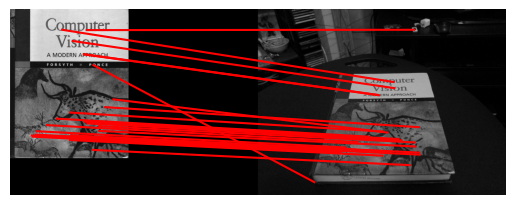

In [ ]:
# Feel free to play around with these parameters
# BUT when submitting the report use the original images
image1_name = "cv_cover.jpg"
image2_name = "cv_desk.png"
ratio = 0.7
sigma = 0.15

image1_path = os.path.join(DATA_DIR, image1_name)
image2_path = os.path.join(DATA_DIR, image2_name)

image1 = cv2.imread(image1_path)
image2 = cv2.imread(image2_path)

#bgr to rgb
if len(image1.shape) == 3 and image1.shape[2] == 3:
  image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

if len(image2.shape) == 3 and image2.shape[2] == 3:
  image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

displayMatched(image1, image2, ratio, sigma)

### Q2.1.5 (10 points):

Experiment with different sigma and ratio values. Conduct a small ablation study, and include the figures displaying the matched features with various parameters in your write-up. Explain the effect of these two paremeters respectively.

---

Explain the effect of these two parameters: Sigma sets the sensitivity for the FAST corner detector. A lower sigma means the detector is more permissive and will detect many more corners, and the ratio parameter is used in the ratio test during BRIEF descriptor matching. A lower ratio value makes the test more strict.

---

Testing with sigma= [0.1, 0.2, 0.3] and ratio= [0.35, 0.5, 0.8]
Displaying matches for ratio:  0.35  and sigma:  0.1


<ipython-input-1-7c3b2f3eac05>:60: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 if img[int(center[0]+row1)][int(center[1]+col1)] < img[int(center[0]+row2)][int(center[1]+col2)] else 0


Testing with sigma= [0.1, 0.2, 0.3] and ratio= [0.35, 0.5, 0.8]
Displaying matches for ratio:  0.5  and sigma:  0.1


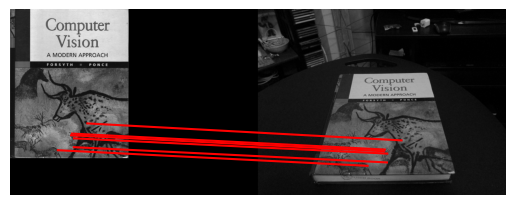

Testing with sigma= [0.1, 0.2, 0.3] and ratio= [0.35, 0.5, 0.8]
Displaying matches for ratio:  0.8  and sigma:  0.1


Testing with sigma= [0.1, 0.2, 0.3] and ratio= [0.35, 0.5, 0.8]
Displaying matches for ratio:  0.35  and sigma:  0.2


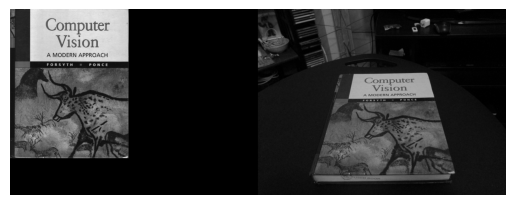

Testing with sigma= [0.1, 0.2, 0.3] and ratio= [0.35, 0.5, 0.8]
Displaying matches for ratio:  0.5  and sigma:  0.2


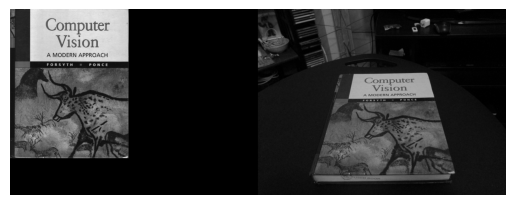

Testing with sigma= [0.1, 0.2, 0.3] and ratio= [0.35, 0.5, 0.8]
Displaying matches for ratio:  0.8  and sigma:  0.2


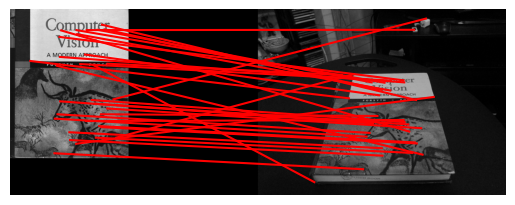

Testing with sigma= [0.1, 0.2, 0.3] and ratio= [0.35, 0.5, 0.8]
Displaying matches for ratio:  0.35  and sigma:  0.3


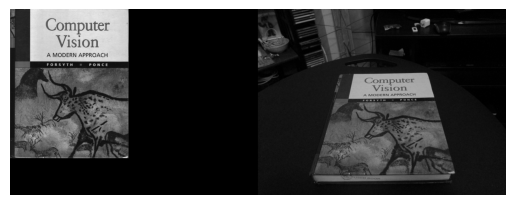

Testing with sigma= [0.1, 0.2, 0.3] and ratio= [0.35, 0.5, 0.8]
Displaying matches for ratio:  0.5  and sigma:  0.3


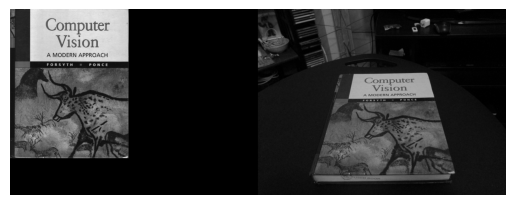

Testing with sigma= [0.1, 0.2, 0.3] and ratio= [0.35, 0.5, 0.8]
Displaying matches for ratio:  0.8  and sigma:  0.3


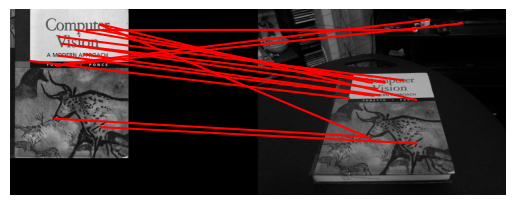

In [ ]:
image1_name = "cv_cover.jpg"
image2_name = "cv_desk.png"

image1_path = os.path.join(DATA_DIR, image1_name)
image2_path = os.path.join(DATA_DIR, image2_name)

image1 = cv2.imread(image1_path)
image2 = cv2.imread(image2_path)

#bgr to rgb
if len(image1.shape) == 3 and image1.shape[2] == 3:
  image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

if len(image2.shape) == 3 and image2.shape[2] == 3:
  image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

# ===== your code here! =====
# Experiment with different sigma and ratio values.
# Use displayMatches to visualize.
# Include the matched feature figures in the write-up.
sigma = [0.1, 0.2, 0.3]
ratio = [0.35, 0.5, 0.8 ]
for s in sigma:
  for r in ratio:
    print("Testing with sigma=", sigma, "and ratio=", ratio)
    displayMatched(image1, image2, r, s)
    plt.show()
# ==== end of code ====

### Q2.1.6 (10 points):

#### Implement the function briefRot

In [ ]:
def briefRot(min_deg, max_deg, deg_inc, ratio, sigma, filename):
    """
    Tests Brief with rotations.

    Input
    -----
    min_deg: minimum degree to rotate image
    max_deg: maximum degree to rotate image
    deg_inc: number of degrees to increment when iterating
    ratio: ratio for BRIEF feature descriptor
    sigma: threshold for corner detection using FAST feature detector
    filename: filename of image to rotate

    """

    if not os.path.exists(RES_DIR):
      raise RuntimeError('RES_DIR does not exist. did you run all cells?')

    # Read the image and convert bgr to rgb
    image_path = os.path.join(DATA_DIR, filename)
    image = cv2.imread(image_path)
    if len(image.shape) == 3 and image.shape[2] == 3:
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    match_degrees = [] # stores the degrees of rotation
    match_counts = [] # stores the number of matches at each degree of rotation

    for i in range(min_deg, max_deg, deg_inc):
        print(i)

        # ===== your code here! =====
        # TODO: Rotate Image (Hint: use scipy.ndimage.rotate)
        rotated = scipy.ndimage.rotate(image, i)

        # TODO: Match features in images
        matches, locs1, locs2 = matchPics(image, rotated, ratio, sigma)
        # TODO: visualizes matches at at least 3 different orientations
        # to include in your report
        # (Hint: use plotMatches)
        if i in [0,90,180]:
          plt.figure()
          plotMatches(image, rotated, matches, locs1, locs2)
          plt.show()
        # TODO: Update match_degrees and match_counts (see descriptions above)
        match_degrees.append(i)
        match_counts.append(len(matches))

        # ==== end of code ====

    # Save to pickle file
    matches_to_save = [match_counts, match_degrees, deg_inc]
    write_pickle(ROT_MATCHES_PATH, matches_to_save)

def dispBriefRotHist(matches_path=ROT_MATCHES_PATH):
    # Check if pickle file exists
    if not os.path.exists(matches_path):
      raise RuntimeError('matches_path does not exist. did you call briefRot?')

    # Read from pickle file
    match_counts, match_degrees, deg_inc = read_pickle(matches_path)

    # Display histogram
    # Bins are centered and separated every 10 degrees
    plt.figure()
    bins = [x - deg_inc/2 for x in match_degrees]
    bins.append(bins[-1] + deg_inc)
    plt.hist(match_degrees, bins=bins, weights=match_counts, log=True)
    #plt.hist(match_degrees, bins=[10 * (x-0.5) for x in range(37)], weights=match_counts, log=True)
    plt.title("Histogram of BREIF matches")
    plt.ylabel("# of matches")
    plt.xlabel("Rotation (deg)")
    plt.tight_layout()

    output_path = os.path.join(RES_DIR, 'histogram.png')
    plt.savefig(output_path)

#### Visualize the matches under rotation

See debugging tips in handout.


In [ ]:
# defaults are:
# min_deg = 0
# max_deg = 360
# deg_inc = 10
# ratio = 0.7
# sigma = 0.15
# filename = 'cv_cover.jpg'

# Controls the rotation degrees
min_deg = 0
max_deg = 360
deg_inc = 10

# Brief feature descriptor and Fast feature detector paremeters
# (change these if you want to use different values)
ratio = 0.7
sigma = 0.15

# image to rotate and match
# (no need to change this but can if you want to experiment)
filename = 'cv_cover.jpg'

# Call briefRot
briefRot(min_deg, max_deg, deg_inc, ratio, sigma, filename)

0


<ipython-input-1-7c3b2f3eac05>:60: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 if img[int(center[0]+row1)][int(center[1]+col1)] < img[int(center[0]+row2)][int(center[1]+col2)] else 0


<Figure size 640x480 with 0 Axes>

10
20
30
40
50
60
70
80
90


<Figure size 640x480 with 0 Axes>

100
110
120
130
140
150
160
170
180


<Figure size 640x480 with 0 Axes>

190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350


#### Plot the histogram

See debugging tips in handout.

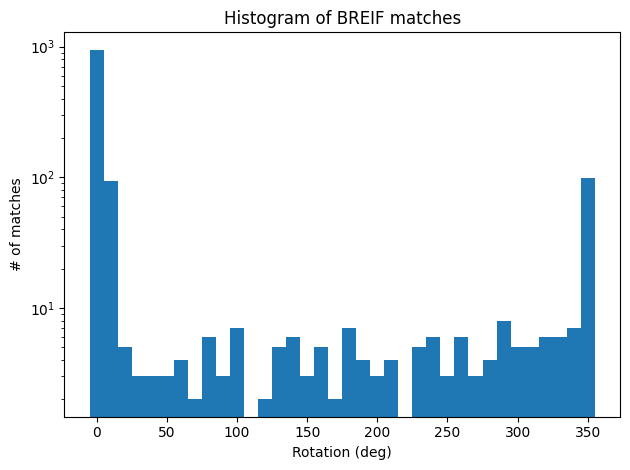

In [ ]:
dispBriefRotHist()

---

Explain why you think the BRIEF descriptor behves this way: This happens because BRIEF samples intensities in a fixed local pattern around each keypoint. As the image rotates, that sampling pattern no longer aligns well with the same features, causing the binary descriptors to differ.

---

### Q2.1.7.1 (Extra Credit - 5 points):

Design a fix to make BRIEF more rotation invariant. Feel free to make any helper functions as necessary. But you cannot use any additional OpenCV or Scikit-Image functions.

In [ ]:
# ===== your code here! =====
# TODO: Define any helper functions here
# (Feel free to put anything in its own cell)
import math
def compute_orientation(I, x, y, patch_size=31):
    """
    Estimate orientation around keypoint (x, y) by summing gradients in a patch.
    I: Grayscale image (float or uint8).
    (x, y): keypoint coordinates (row, col).
    patch_size: size of local patch (odd number).

    Returns: orientation in radians, range [-pi, pi].
    """
    half = patch_size // 2
    # Clamp patch boundaries
    r0, r1 = max(0, x-half), min(I.shape[0], x+half+1)
    c0, c1 = max(0, y-half), min(I.shape[1], y+half+1)

    patch = I[r0:r1, c0:c1].astype(float)

    # Simple central difference gradients
    gx = np.zeros_like(patch)
    gy = np.zeros_like(patch)
    gx[:, 1:-1] = patch[:, 2:] - patch[:, :-2]
    gy[1:-1, :] = patch[2:, :] - patch[:-2, :]

    sum_gx = np.sum(gx)
    sum_gy = np.sum(gy)

    return math.atan2(sum_gy, sum_gx)

def rotate_pattern(pattern, theta):
    """
    Rotate a BRIEF sampling pattern by angle theta.
    pattern: array of shape (N, 2), each row = (dx, dy) offsets from keypoint center.
    theta: angle in radians.

    Returns: rotated pattern of shape (N, 2).
    """
    c, s = math.cos(theta), math.sin(theta)
    rot = []
    for (dx, dy) in pattern:
        rdx =  dx*c - dy*s
        rdy =  dx*s + dy*c
        rot.append((rdx, rdy))
    return np.array(rot)

def compute_brief_rot_invariant(I, locs, base_pattern, patch_size=31):
    """
    Compute rotation-invariant BRIEF descriptors at keypoints in 'locs'.
    I: Grayscale image (float or uint8).
    locs: Nx2 array of (row, col) keypoint locations.
    base_pattern: Nx2 array of base (dx, dy) offsets for BRIEF.
    patch_size: local patch size used for orientation estimation.

    Returns:
      desc: [M x K] binary descriptors (M <= N if some keypoints go out of bounds)
      valid_locs: Mx2 array of valid keypoint locations
    """
    desc = []
    valid_locs = []

    # Ensure image is float
    if I.dtype == np.uint8:
        I = I.astype(float)

    for (x, y) in locs:
        x, y = int(x), int(y)

        # 1. Compute local orientation
        theta = compute_orientation(I, x, y, patch_size)

        # 2. Rotate the pattern
        rot_pat = rotate_pattern(base_pattern, theta)

        # 3. Sample intensities
        samples = []
        valid = True
        for (dx, dy) in rot_pat:
            xx = int(round(x + dx))
            yy = int(round(y + dy))
            # Check boundaries
            if xx < 0 or xx >= I.shape[0] or yy < 0 or yy >= I.shape[1]:
                valid = False
                break
            samples.append(I[xx, yy])
        if not valid:
            continue

        bits = []
        for i in range(0, len(samples)-1, 2):
            bit = 1 if samples[i] < samples[i+1] else 0
            bits.append(bit)

        desc.append(bits)
        valid_locs.append((x, y))

    return np.array(desc, dtype=np.uint8), np.array(valid_locs)

# TODO: Feel free to modify the inputs and the function body as necessary
# This is only an outline
def briefRotInvEc(min_deg, max_deg, deg_inc, ratio, sigma, filename):
    """
    Rotation invariant Brief.

    Input
    -----
    min_deg: minimum degree to rotate image
    max_deg: maximum degree to rotate image
    deg_inc: number of degrees to increment when iterating
    ratio: ratio for BRIEF feature descriptor
    sigma: threshold for corner detection using FAST feature detector
    filename: filename of image to rotate

    """

    if not os.path.exists(RES_DIR):
      raise RuntimeError('RES_DIR does not exist. did you run all cells?')

    #Read the image and convert bgr to rgb
    image_path = os.path.join(DATA_DIR, filename)
    image = cv2.imread(image_path)
    if len(image.shape) == 3 and image.shape[2] == 3:
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    match_degrees = [] # stores the degrees of rotation
    match_counts = [] # stores the number of matches at each degree of rotation

    for i in range(min_deg, max_deg, deg_inc):
        print(i)

        # TODO: Rotate Image (Hint: use scipy.ndimage.rotate)
        rotated = scipy.ndimage.rotate(image, i, reshape=False)
        # TODO: Brief matcher that is rotation invariant
        if len(image.shape) == 3:
            gray = skimage.color.rgb2gray(image)
        else:
            gray = image.astype(float) / 255.0
        if len(rotated.shape) == 3:
            rot_gray = skimage.color.rgb2gray(rotated)
        else:
            rot_gray = rotated.astype(float) / 255.0
        # Feel free to define additional helper functions as necessary
        locs_orig = corner_detection(gray, sigma)
        locs_rot = corner_detection(rot_gray, sigma)

        base_pattern = np.array([
            (-4, -4), (4, 4),
            (-4, 4), (4, -4),
            (2, 0), (-2, 0),
            (0, 2), (0, -2)
        ], dtype=float)

        # Compute rotation invariant BRIEF descriptors
        desc_orig, locs_orig = compute_brief_rot_invariant(gray, locs_orig, base_pattern)
        desc_rot, locs_rot = compute_brief_rot_invariant(rot_gray, locs_rot, base_pattern)

        # Match features using the descriptors
        matches = briefMatch(desc_orig, desc_rot, ratio)
        # TODO: visualizes matches at at least 3 different orientations
        # to include in your report
        # (Hint: use plotMatches)
        if i in [0,90,180,270]:
            plt.figure()
            plotMatches(image, rotated, matches, locs_orig, locs_rot)
            plt.show()
        # TODO: Update match_degrees and match_counts (see descriptions above)
        match_degrees.append(i)
        match_counts.append(len(matches))
    # Save to pickle file
    matches_to_save = [match_counts, match_degrees, deg_inc]
    write_pickle(ROT_INV_MATCHES_PATH, matches_to_save)

# ==== end of code ====

#### Visualize your implemented function


0


<Figure size 640x480 with 0 Axes>

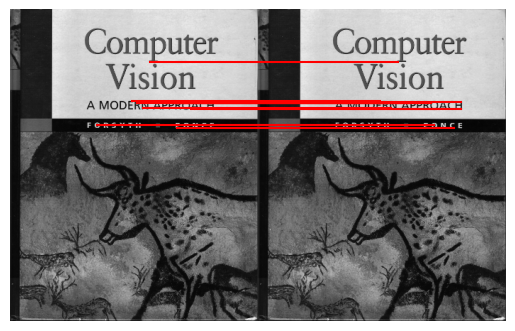

10
20
30
40
50
60
70
80
90


<Figure size 640x480 with 0 Axes>

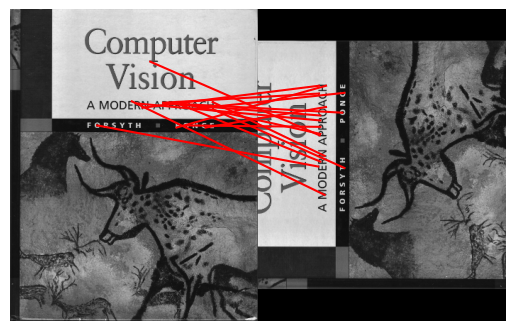

100
110
120
130
140
150
160
170
180


<Figure size 640x480 with 0 Axes>

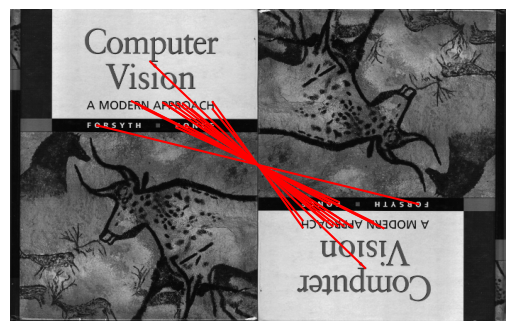

190
200
210
220
230
240
250
260
270


<Figure size 640x480 with 0 Axes>

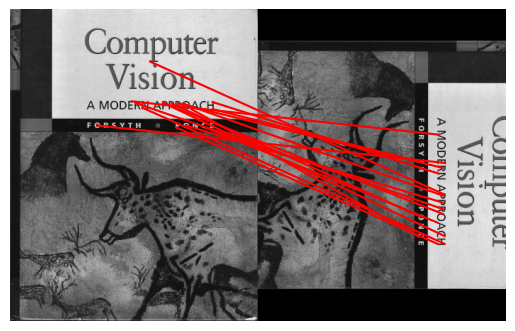

280
290
300
310
320
330
340
350


In [ ]:
min_deg = 0
max_deg = 360
deg_inc = 10
filename = 'cv_cover.jpg'

# ===== your code here! =====
# TODO: Call briefRotInvEc and visualize
ratio = 0.7
sigma = 0.15
briefRotInvEc(min_deg, max_deg, deg_inc, ratio, sigma, filename)
# ==== end of code ====


#### Plot Histogram

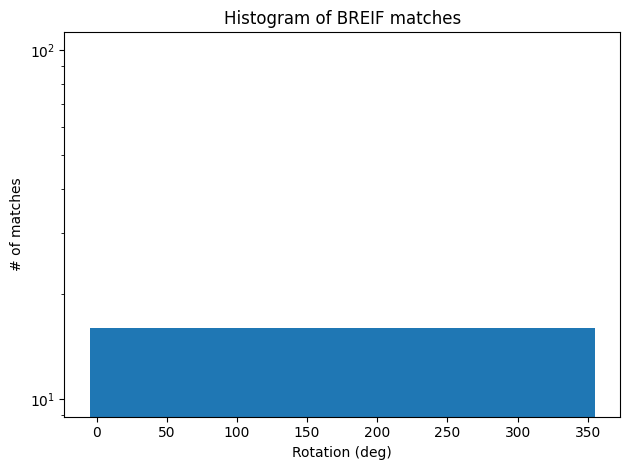

In [ ]:
dispBriefRotHist(matches_path=ROT_INV_MATCHES_PATH)

---

Compare the histograms with an without rotation invariance. Explain your rotation invariant design and how you selected any parameters that you used: Without rotation invariance, the histogram of matches drops steeply as the rotation angle deviates from 0° (or 360°), indicating that the standard BRIEF descriptor fails to match features when the image is rotated. In contrast, with the rotation-invariant design, the histogram remains much flatter across different rotation angles, meaning that the number of matches stays relatively consistent even for large rotations.

---

### Q2.1.7.2 (Extra Credit - 5 points):

Design a fix to make BRIEF more scale invariant. Feel free to make any helper functions as necessary. But you cannot use any additional OpenCV or Scikit-Image functions.


In [ ]:
# ===== your code here! =====
# TODO: Define any helper functions here
# (Feel free to put anything in its own cell)
def computeBriefScaleInv(I, locs, base_pattern, inv_scale):
    """
    Compute scale-invariant BRIEF descriptors by scaling the sampling pattern.

    Input
    -----
    I: Grayscale image normalized to [0,1].
    locs: Nx2 array of keypoint coordinates.
    base_pattern: Mx4 array, each row is [dx1, dy1, dx2, dy2] defining a BRIEF pair.
    inv_scale: inverse scale factor to apply to the pattern (e.g., 2 for half-sized images).

    Returns
    -------
    desc: Array of binary descriptors (each row is a binary vector)
    valid_locs: Array of keypoints (only those for which the pattern is fully in bounds)
    """
    desc = []
    valid_locs = []
    for (x, y) in locs:
        x_int = int(round(x))
        y_int = int(round(y))
        descriptor = []
        valid = True
        for (dx1, dy1, dx2, dy2) in base_pattern:
            # Scale the offsets by the inverse scale factor.
            dx1s = dx1 * inv_scale
            dy1s = dy1 * inv_scale
            dx2s = dx2 * inv_scale
            dy2s = dy2 * inv_scale
            xx1 = int(round(x_int + dx1s))
            yy1 = int(round(y_int + dy1s))
            xx2 = int(round(x_int + dx2s))
            yy2 = int(round(y_int + dy2s))
            # Check if sampling positions are within bounds.
            if xx1 < 0 or xx1 >= I.shape[0] or yy1 < 0 or yy1 >= I.shape[1] or \
               xx2 < 0 or xx2 >= I.shape[0] or yy2 < 0 or yy2 >= I.shape[1]:
                valid = False
                break
            # Form one bit by comparing intensities.
            bit = 1 if I[xx1, yy1] < I[xx2, yy2] else 0
            descriptor.append(bit)
        if valid:
            desc.append(descriptor)
            valid_locs.append((x, y))
    return np.array(desc, dtype=np.uint8), np.array(valid_locs)


# TODO: Modify the inputs and the function body as necessary
def briefScaleInvEc(ratio, sigma, filename):

    #Read the image and convert bgr to rgb
    image_path = os.path.join(DATA_DIR, filename)
    image = cv2.imread(image_path)
    if len(image.shape) == 3 and image.shape[2] == 3:
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    match_scales = [] # stores the scaling factors
    match_counts = [] # stores the number of matches at each scaling factor

    for i in [1]:
        # Scale Image
        image_scale = cv2.resize(image,(int(image.shape[1]/(2**i)),
                                        int(image.shape[0]/(2**i))),
                                 interpolation = cv2.INTER_AREA)

        # TODO: Brief matcher that is scale invariant
        # Feel free to define additional helper functions as necessary
        if len(image.shape) == 3:
            I_gray = skimage.color.rgb2gray(image)
        else:
            I_gray = image.astype(np.float64)/255.0
        if len(image_scale.shape) == 3:
            I_scale_gray = skimage.color.rgb2gray(image_scale)
        else:
            I_scale_gray = image_scale.astype(np.float64)/255.0

        # Detect corners in both images
        locs_orig = corner_detection(I_gray, sigma)
        locs_scale = corner_detection(I_scale_gray, sigma)

        base_pattern = np.array([
            [-3, 0, 3, 0],
            [0, -3, 0, 3],
            [-2, -2, 2, 2],
            [-2, 2, 2, -2]
        ], dtype=float)

        inv_scale = 2**i
        # Compute scale-invariant BRIEF descriptors on both images
        desc_orig, locs_orig = computeBriefScaleInv(I_gray, locs_orig, base_pattern, inv_scale)
        desc_scale, locs_scale = computeBriefScaleInv(I_scale_gray, locs_scale, base_pattern, inv_scale)
        # Match features
        matches = briefMatch(desc_orig, desc_scale, ratio)
        # Compare to regular matchPics
        matches_orig, locs1_orig, locs2_orig = matchPics(image,
                                                         image_scale,
                                                         ratio, sigma)

        print('plotting non-scale invariant scale: ', 2**i)
        plotMatches(image, image_scale, matches_orig, locs1_orig,
                    locs2_orig)
        print('plotting scale-invariant: ', 2**i)
        plotMatches(image, image_scale, matches, locs_orig, locs_scale)

        # Update
        match_scales.append(2**i)
        match_counts.append(len(matches))

# ==== end of code ====

#### Visualize your implemented function

<ipython-input-1-7c3b2f3eac05>:60: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 if img[int(center[0]+row1)][int(center[1]+col1)] < img[int(center[0]+row2)][int(center[1]+col2)] else 0


plotting non-scale invariant scale:  2


plotting scale-invariant:  2


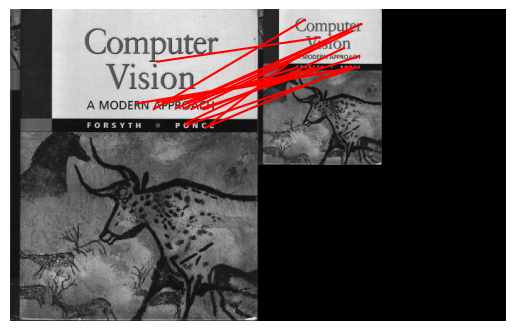

In [ ]:
# ===== your code here! =====
# TODO: Call briefScaleInvEc and visualize
# You may change any parameters and the function body as necessary

filename = 'cv_cover.jpg'

ratio = 0.7
sigma = 0.15

briefScaleInvEc(ratio, sigma, filename)
# ==== end of code ====

---

Explain your scale invariant design and how you selected any parameters that you used: By scaling the BRIEF sampling pattern according to the image’s scale change, picture design preserves the relative structure of the local image region, therefore achieving more consistent matching performance across scales.

---


## Q2.2 Homography Computation

### Q2.2.1 (15 Points):

Implement the function computeH

In [ ]:
def computeH(x1, x2):
    """
    Compute the homography between two sets of points

    Input
    -----
    x1, x2: Sets of points

    Returns
    -------
    H2to1: 3x3 homography matrix that best transforms x2 to x1
    """

    if x1.shape != x2.shape:
        raise RuntimeError('number of points do not match')

    # ===== your code here! =====
    # TODO: Compute the homography between two sets of points

    N = x1.shape[0]
    A = []
    for i in range(N):
        x1_i, y1_i = x1[i]
        x2_i, y2_i = x2[i]
        A.append([x2_i, y2_i, 1, 0, 0, 0, -x1_i*x2_i, -x1_i*y2_i, -x1_i])
        A.append([0, 0, 0, x2_i, y2_i, 1, -y1_i*x2_i, -y1_i*y2_i, -y1_i])
    A = np.array(A)

    U, S, Vh = np.linalg.svd(A)
    h = Vh[-1, :]
    H2to1 = h.reshape((3, 3))

    # ==== end of code ====

    return H2to1

### Q2.2.2 (10 points):

Implement the function computeH_norm

In [ ]:
def computeH_norm(x1, x2):
    """
    Compute the homography between two sets of points using normalization

    Input
    -----
    x1, x2: Sets of points

    Returns
    -------
    H2to1: 3x3 homography matrix that best transforms x2 to x1
    """

    # ===== your code here! =====

    # TODO: Compute the centroid of the points
    centroid1 = np.mean(x1, axis=0)
    centroid2 = np.mean(x2, axis=0)
    # TODO: Shift the origin of the points to the centroid
    x1_shifted = x1 - centroid1
    x2_shifted = x2 - centroid2

    # TODO: Normalize the points so that the largest distance from the
    # origin is equal to sqrt(2)
    max_dist1 = np.max(np.sqrt(np.sum(x1_shifted**2, axis=1)))
    max_dist2 = np.max(np.sqrt(np.sum(x2_shifted**2, axis=1)))
    scale1 = np.sqrt(2) / max_dist1
    scale2 = np.sqrt(2) / max_dist2

    x1_normalized = x1_shifted * scale1
    x2_normalized = x2_shifted * scale2
    # TODO: Similarity transform 1
    T1 = np.array([
        [scale1,     0,  -scale1 * centroid1[0]],
        [    0, scale1,  -scale1 * centroid1[1]],
        [    0,     0,                     1]
    ])
    # TODO: Similarity transform 2
    T2 = np.array([
        [scale2,     0,  -scale2 * centroid2[0]],
        [    0, scale2,  -scale2 * centroid2[1]],
        [    0,     0,                     1]
    ])

    # TODO: Compute homography
    Hnorm = computeH(x1_normalized, x2_normalized)

    # TODO: Denormalization
    H2to1 = np.linalg.inv(T1) @ Hnorm @ T2

    # ==== end of code ====

    return H2to1

### Q2.2.3 (25 points):

Implement RANSAC

In [ ]:
def computeH_ransac(locs1, locs2, max_iters, inlier_tol):
    """
    Estimate the homography between two sets of points using ransac

    Input
    -----
    locs1, locs2: Lists of points
    max_iters: the number of iterations to run RANSAC for
    inlier_tol: the tolerance value for considering a point to be an inlier

    Returns
    -------
    bestH2to1: 3x3 homography matrix that best transforms locs2 to locs1
    inliers: indices of RANSAC inliers

    """

    # ===== your code here! =====

    # TODO:
    # Compute the best fitting homography using RANSAC
    # given a list of matching points locs1 and loc2
    N = min(locs1.shape[0], locs2.shape[0])
    locs1 = locs1[:N]
    locs2 = locs2[:N]

    best_inlier_count = 0
    bestH2to1 = None
    best_inliers = np.zeros(N, dtype=bool)

    for _ in range(max_iters):
        # Randomly select 4 correspondences
        idx = np.random.choice(N, 4, replace=False)
        sample_x1 = locs1[idx]
        sample_x2 = locs2[idx]

        # Compute homography using normalized coordinates
        H = computeH_norm(sample_x1, sample_x2)

        # Transform all points in locs2 using H
        locs2_h= np.hstack((locs2, np.ones((N, 1))))
        projected = locs2_h @ H.T
        projected = projected[:, :2] / projected[:, 2:]


        # Compute Euclidean distance
        errors = np.linalg.norm(projected - locs1, axis=1)

        # Determine inliers (error below tolerance)
        inlier_mask = (errors < inlier_tol)
        inlier_count = np.sum(inlier_mask)

        # Update best homography if this one has more inliers
        if inlier_count > best_inlier_count:
            best_inlier_count = inlier_count
            bestH2to1 = H
            best_inliers = inlier_mask

    # ==== end of code ====

    return bestH2to1, best_inliers

### Q2.2.4 (10 points):

#### Implement the function compositeH

In [ ]:
def compositeH(H2to1, template, img):
    """
    Returns the composite image.

    Input
    -----
    H2to1: Homography from image to template
    template: template image to be warped
    img: background image

    Returns
    -------
    composite_img: Composite image

    """

    # ===== your code here! =====
    # TODO: Create a composite image after warping the template image on top
    # of the image using the homography

    warped = cv2.warpPerspective(template, H2to1, (img.shape[1], img.shape[0]))
    warped_template = warped
    # Create a mask of non-zero (warped) pixels
    if warped_template.ndim == 3:
        mask = np.any(warped_template != 0, axis=2)
    else:
        mask = warped_template != 0

    composite_img = img.copy()
    composite_img[mask,:] = warped_template[mask,:]

    # ==== end of code ====

    return composite_img

#### Implement the function warpImage

In [ ]:
def warpImage(ratio, sigma, max_iters, inlier_tol):
    """
    Warps hp_cover.jpg onto the book cover in cv_desk.png.

    Input
    -----
    ratio: ratio for BRIEF feature descriptor
    sigma: threshold for corner detection using FAST feature detector
    max_iters: the number of iterations to run RANSAC for
    inlier_tol: the tolerance value for considering a point to be an inlier

    """

    hp_cover = skimage.io.imread(os.path.join(DATA_DIR, 'hp_cover.jpg'))
    cv_cover = skimage.io.imread(os.path.join(DATA_DIR, 'cv_cover.jpg'))
    cv_desk = skimage.io.imread(os.path.join(DATA_DIR, 'cv_desk.png'))
    cv_desk = cv_desk[:, :, :3]

    # ===== your code here! =====

    # TODO: match features between cv_desk and cv_cover using matchPics
    matches, locs1, locs2 = matchPics(cv_desk, cv_cover, ratio, sigma)
    locs1_matched  = locs1[matches[:, 0]]
    locs2_matched = locs2[matches[:, 1]]
    # TODO: Scale matched pixels in cv_cover to size of hp_cover
    locs1_matched_switch  = locs1_matched[:, [1, 0]].astype(float)
    locs2_matched_switch = locs2_matched[:, [1, 0]].astype(float)

    # Scale x and y
    scale_x = hp_cover.shape[1] / float(cv_cover.shape[1])
    scale_y = hp_cover.shape[0] / float(cv_cover.shape[0])
    locs2_matched_switch[:, 0] *= scale_x
    locs2_matched_switch[:, 1] *= scale_y


    # TODO: Get homography by RANSAC using computeH_ransac
    H2to1 = computeH_ransac(locs1_matched_switch, locs2_matched_switch, max_iters, inlier_tol)[0]
    # TODO: Warp cv_cover onto hp_cover using compositeH
    composite_img = compositeH(H2to1, hp_cover, cv_desk)
    # TODO: Overlay using compositeH to return composite_img
    # ==== end of code ====

    plt.imshow(composite_img)
    plt.show()

#### Visualize composite image

<ipython-input-1-7c3b2f3eac05>:60: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 if img[int(center[0]+row1)][int(center[1]+col1)] < img[int(center[0]+row2)][int(center[1]+col2)] else 0


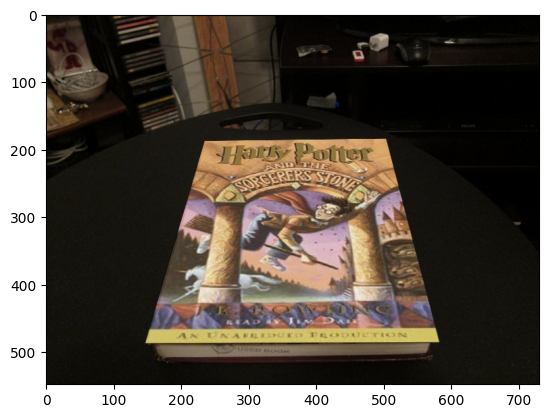

In [ ]:
# defaults are:
# ratio = 0.7
# sigma = 0.15
# max_iters = 600
# inlier_tol = 1.0

# (no need to change this but can if you want to experiment)
ratio = 0.7
sigma = 0.15
max_iters = 600
inlier_tol = 1.0

warpImage(ratio, sigma, max_iters, inlier_tol)

### Q2.2.5 (10 points):

Conduct ablation study with various max_iters and inlier_tol values. Plot the result images and explain the effect of these two parameters respectively.

Running warpImage with max_iters=10, inlier_tol=0.1


<ipython-input-1-7c3b2f3eac05>:60: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 if img[int(center[0]+row1)][int(center[1]+col1)] < img[int(center[0]+row2)][int(center[1]+col2)] else 0


Running warpImage with max_iters=10, inlier_tol=5


<ipython-input-1-7c3b2f3eac05>:60: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 if img[int(center[0]+row1)][int(center[1]+col1)] < img[int(center[0]+row2)][int(center[1]+col2)] else 0


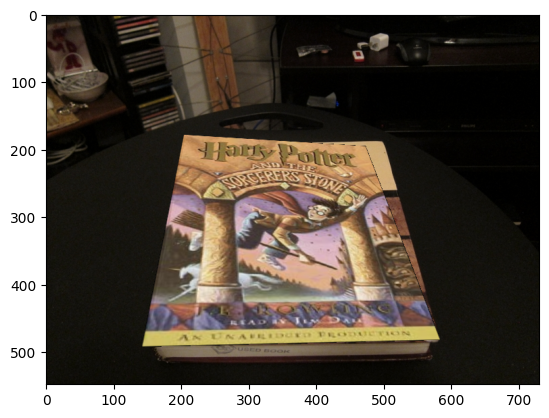

Running warpImage with max_iters=10000, inlier_tol=0.1


<ipython-input-1-7c3b2f3eac05>:60: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 if img[int(center[0]+row1)][int(center[1]+col1)] < img[int(center[0]+row2)][int(center[1]+col2)] else 0


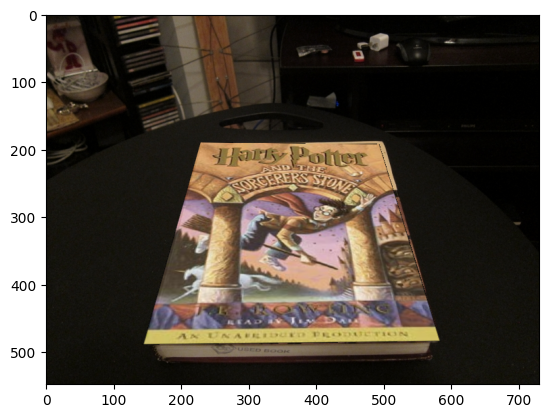

Running warpImage with max_iters=10000, inlier_tol=5


<ipython-input-1-7c3b2f3eac05>:60: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 if img[int(center[0]+row1)][int(center[1]+col1)] < img[int(center[0]+row2)][int(center[1]+col2)] else 0


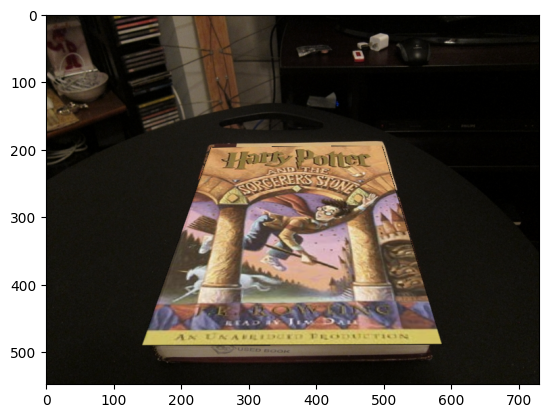

In [ ]:
# ===== your code here! =====
# Experiment with different max_iters and inlier_tol values.
# Include the result images in the write-up.
ratio = 0.7
sigma = 0.15
max_iters = [10, 10000]
inlier_tol = [0.1,5]

for mi in max_iters:
    for tol in inlier_tol:
        print(f"Running warpImage with max_iters={mi}, inlier_tol={tol}")
        warpImage(ratio, sigma, mi, tol)
# ==== end of code ====

---


Explain the effect of max_iters and inlier_tol: Max_iteration parameter controls how many random samples RANSAC will try to compute a homography. A large parameter increases the chance of finding a model with a large consensus set. inlier_tol is the error threshold used to decide if a projected point is close enough to its corresponding point to be considered an inlier

---

# Q3 Create a Simple Panorama

## Q3.1 Create a panorama (10 points):

#### Implement the function createPanorama

In [ ]:
def createPanorama(left_im, right_im, ratio, sigma, max_iters, inlier_tol):
    """
    Create a panorama augmented reality application by computing a homography
    and stitching together a left and right image.

    Input
    -----
    left_im: left image
    right_im: right image
    ratio: ratio for BRIEF feature descriptor
    sigma: threshold for corner detection using FAST feature detector
    max_iters: the number of iterations to run RANSAC for
    inlier_tol: the tolerance value for considering a point to be an inlier

    Returns
    -------
    panorama_im: Stitched together panorama

    """

    # ===== your code here! =====
    # TODO: match features between images
    # This can be done using matchPics, cpselect, or any other function.
    matches, locs_left, locs_right = matchPics(left_im, right_im, ratio, sigma)

    # Convert points to (x, y) order (swap columns)
    locs_left_xy  = locs_left[:, [1, 0]].astype(float)
    locs_right_xy = locs_right[:, [1, 0]].astype(float)

    # Extract only the matched points using the indices from matches
    left_matched  = locs_left_xy[matches[:, 0]]
    right_matched = locs_right_xy[matches[:, 1]]

    # TODO: Get homography by RANSAC using computeH_ransac
    H = computeH_ransac(left_matched, right_matched, max_iters, inlier_tol)[0]
    # Inverse to warp the left image into the right
    H_inv = np.linalg.inv(H)

    # Get dimensions of left and right images
    h_left, w_left = left_im.shape[:2]
    h_right, w_right = right_im.shape[:2]

    left_corners = np.array([[0, 0],
                             [w_left, 0],
                             [w_left, h_left],
                             [0, h_left]], dtype=np.float32)
    # Warp left image corners
    ones = np.ones((4, 1), dtype=np.float32)
    left_corners_h = np.hstack((left_corners, ones))
    warped_left_corners = (H_inv @ left_corners_h.T).T
    warped_left_corners = warped_left_corners[:, :2] / warped_left_corners[:, 2][:, np.newaxis]

    # Compute corners of the right image
    right_corners = np.array([[0, 0],
                              [w_right, 0],
                              [w_right, h_right],
                              [0, h_right]], dtype=np.float32)

    # Combine the warped left corners and right image corners
    all_corners = np.vstack((warped_left_corners, right_corners))
    min_xy = np.min(all_corners, axis=0)
    max_xy = np.max(all_corners, axis=0)

    # Compute the size of the output canvas.
    out_w = int(np.ceil(max_xy[0] - min_xy[0]))
    out_h = int(np.ceil(max_xy[1] - min_xy[1]))

    # Compute a translation homography
    T = np.array([[1, 0, -min_xy[0]],
                  [0, 1, -min_xy[1]],
                  [0, 0, 1]], dtype=np.float32)

    # TODO: Stich together the two images
    # Requires the use of cv2.warpPerspective
    warped_left = cv2.warpPerspective(left_im, T @ H_inv, (out_w, out_h))
    warped_right = cv2.warpPerspective(right_im, T, (out_w, out_h))

    # Make panorama image
    panorama_im = warped_right.copy()
    mask = (warped_left.sum(axis=2) > 0)
    panorama_im[mask] = warped_left[mask]

    # Crop image

    nonzero_coords = np.nonzero(panorama_im.sum(axis=2))
    min_row, max_row = np.min(nonzero_coords[1]), np.max(nonzero_coords[1])
    min_col, max_col = np.min(nonzero_coords[0]), np.max(nonzero_coords[0])

    panorama_im = panorama_im[min_row:max_row, min_col:max_col]

    # ==== end of code ====

    return panorama_im.astype(np.uint8)

#### Visualize Panorama

Make sure to use **your own images** and **include them as well as the result** in the report.

<ipython-input-1-7c3b2f3eac05>:60: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 if img[int(center[0]+row1)][int(center[1]+col1)] < img[int(center[0]+row2)][int(center[1]+col2)] else 0


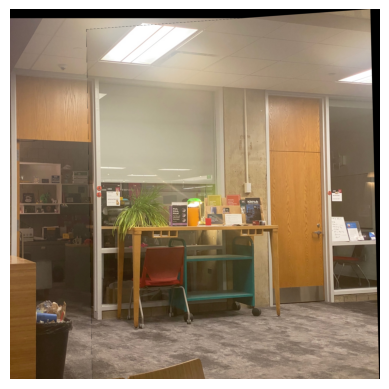

In [ ]:
left_im_path = os.path.join(DATA_DIR, 'pic3.jpg')
left_im = skimage.io.imread(left_im_path)
right_im_path = os.path.join(DATA_DIR, 'pic4.jpg')
right_im = skimage.io.imread(right_im_path)

# Feel free to adjust as needed
ratio = 0.7
sigma = 0.15
max_iters = 600
inlier_tol = 1.5

panorama_im = createPanorama(left_im, right_im, ratio, sigma, max_iters, inlier_tol)







plt.imshow(panorama_im)
plt.axis('off')
plt.show()

In [1]:
### END
!jupyter nbconvert --to pdf /

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono
  fonts-texgyre fonts-urw-base35 libapache-pom-java libcommons-logging-java
  libcommons-parent-java libfontbox-java libfontenc1 libgs9 libgs9-common
  libidn12 libijs-0.35 libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1
  libruby3.0 libsynctex2 libteckit0 libtexlua53 libtexluajit2 libwoff1
  libzzip-0-13 lmodern poppler-data preview-latex-style rake ruby
  ruby-net-telnet ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0
  rubygems-integration t1utils teckit tex-common tex-gyre texlive-base
  texlive-binaries texlive-latex-base texlive-latex-extra
  texlive-latex-recommended texlive-pictures tipa xfonts-encodings
  xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf libavalon-framework-java
  libcommons-logging-java-doc libexcalibu

In [ ]:
### END


















































































































































